<a href="https://colab.research.google.com/github/julballa/LatentLattice/blob/main/escnn_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# set current directory
# this should be the Google Drive folder where your file(s) are located
%cd /content/drive/MyDrive/lattices

## verify current directory
!ls /content/drive/MyDrive/lattices

# choose where you want your project files to be saved
project_folder = "/content/drive/MyDrive/lattices"

Mounted at /content/drive
/content/drive/MyDrive/lattices
12x12_train.pt	12x12_val.pt  ten_square_test.pt  ten_square_train.pt  ten_square_val.pt


In [ ]:
!pip install git+https://github.com/AMLab-Amsterdam/lie_learn escnn

  Cloning https://github.com/AMLab-Amsterdam/lie_learn to /tmp/pip-req-build-ggnqgrf4
  Running command git clone --filter=blob:none --quiet https://github.com/AMLab-Amsterdam/lie_learn /tmp/pip-req-build-ggnqgrf4
  Resolved https://github.com/AMLab-Amsterdam/lie_learn to commit 1ccc2106e402d517a29de5438c9367c959e67338
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23

# Define model

In [ ]:
# import torch.nn as nn
# from escnn.nn import R2Conv, R2ConvTransposed, LeakyReLU, ReLU, GroupPooling, GeometricTensor, FieldType, InnerBatchNorm
# from escnn.gspaces import flipRot2dOnR2

# # Encoder -- 2 layer network for REGULAR Rep

# class Encoder(nn.Module):
#     def __init__(self, in_type, out_type):
#         super().__init__()
#         self.conv1 = R2Conv(in_type, out_type, kernel_size=3, stride=1)
#         self.bn1 = InnerBatchNorm(out_type)
#         self.act1 = ReLU(out_type)
#         self.conv2 = R2Conv(out_type, out_type, kernel_size=3, stride=1)
#         self.bn2 = InnerBatchNorm(out_type)
#         self.act2 = ReLU(out_type)
#         self.pool = GroupPooling(out_type)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.act1(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.act2(x)
#         return x

# # Decoder
# class Decoder(nn.Module):
#     def __init__(self, in_type, out_type):
#         super().__init__()
#         self.conv1 = R2ConvTransposed(in_type, out_type, kernel_size=3, stride=1)
#         self.bn1 = InnerBatchNorm(out_type)
#         self.act1 = ReLU(out_type)
#         self.conv2 = R2ConvTransposed(out_type, out_type, kernel_size=3, stride=1)
#         self.bn2 = InnerBatchNorm(out_type)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.act1(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         return x

# class AutoEncoder(nn.Module):
#     def __init__(self, in_type, out_type, latent_type):
#         super().__init__()
#         self.in_type = in_type
#         self.out_type = out_type
#         self.latent_type = latent_type

#         self.encoder = Encoder(in_type, latent_type)
#         self.decoder = Decoder(latent_type, out_type)

#     def forward(self, x):
#         x = GeometricTensor(x, self.in_type)
#         z = self.encoder(x)
#         x_hat = self.decoder(z)
#         return x_hat.tensor



In [ ]:
import torch.nn as nn
from escnn.nn import R3Conv, R3ConvTransposed, LeakyReLU, GroupPooling, GeometricTensor, FieldType
from escnn.gspaces.r3 import flipRot3dOnR3
# 2D data imports
from escnn.nn import R2Conv, R2ConvTransposed, PointwiseAvgPool2D
from escnn.gspaces import flipRot2dOnR2

# Encoder -- 2 layer network
class Encoder(nn.Module):
    def __init__(self, in_type, out_type):
        super().__init__()
        self.conv1 = R2Conv(in_type, out_type, kernel_size=3, stride=1)
        self.act1 = LeakyReLU(out_type)
        self.conv2 = R2Conv(out_type, out_type, kernel_size=3, stride=1)
        self.act2 = LeakyReLU(out_type)
        self.pool = GroupPooling(out_type)

       # self.pool = PointwiseAvgPool2D(out_type, kernel_size=3, stride=1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.act2(x)
        return x

# Decoder
class Decoder(nn.Module):
    def __init__(self, in_type, out_type):
        super().__init__()
        self.conv1 = R2ConvTransposed(in_type, out_type, kernel_size=3, stride=1)
        self.act1 = LeakyReLU(out_type)
        self.conv2 = R2ConvTransposed(out_type, out_type, kernel_size=3, stride=1)

    def forward(self, x):
        x = self.conv1(x)
        self.act1 = LeakyReLU(out_type)
        x = self.conv2(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, in_type, out_type, latent_type):
        super().__init__()
        self.in_type = in_type
        self.out_type = out_type
        self.latent_type = latent_type

        self.encoder = Encoder(in_type, latent_type)
        self.decoder = Decoder(latent_type, out_type)

    def forward(self, x):
        x = GeometricTensor(x, self.in_type)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat.tensor

In [ ]:
# import torch.nn as nn
# from escnn.nn import R2Conv, R2ConvTransposed, LeakyReLU, GroupPooling, GeometricTensor, FieldType, IIDBatchNorm2d
# from escnn.gspaces import rot2dOnR2

# # Encoder -- 2 layer with Batch Norm
# class Encoder(nn.Module):
#     def __init__(self, in_type, out_type):
#         super().__init__()
#         self.conv1 = R2Conv(in_type, out_type, kernel_size=3, stride=1)
#         self.bn1 = IIDBatchNorm2d(out_type)
#         self.act1 = LeakyReLU(out_type)
#         self.conv2 = R2Conv(out_type, out_type, kernel_size=3, stride=1)
#         self.bn2 = IIDBatchNorm2d(out_type)
#         self.act2 = LeakyReLU(out_type)
#         self.pool = GroupPooling(out_type)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.act1(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.act2(x)
#         return x

# # Decoder
# class Decoder(nn.Module):
#     def __init__(self, in_type, out_type):
#         super().__init__()
#         self.conv1 = R2ConvTransposed(in_type, out_type, kernel_size=3, stride=1)
#         self.bn1 = IIDBatchNorm2d(out_type)
#         self.act1 = LeakyReLU(out_type)
#         self.conv2 = R2ConvTransposed(out_type, out_type, kernel_size=3, stride=1)
#         self.bn2 = IIDBatchNorm2d(out_type)
#         self.act2 = LeakyReLU(out_type)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.act1(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.act2(x)
#         return x

# class AutoEncoder(nn.Module):
#     def __init__(self, in_type, out_type, latent_type):
#         super().__init__()
#         self.in_type = in_type
#         self.out_type = out_type
#         self.latent_type = latent_type

#         self.encoder = Encoder(in_type, latent_type)
#         self.decoder = Decoder(latent_type, out_type)

#     def forward(self, x):
#         x = GeometricTensor(x, self.in_type)
#         z = self.encoder(x)
#         x_hat = self.decoder(z)
#         return x_hat.tensor


In [ ]:
# import torch.nn as nn
# from escnn.nn import R2Conv, R2ConvTransposed, LeakyReLU, GroupPooling, GeometricTensor, FieldType
# from escnn.gspaces import rot2dOnR2

# # Encoder -- 3 layer network
# class Encoder(nn.Module):
#     def __init__(self, in_type, out_type):
#         super().__init__()
#         self.conv1 = R2Conv(in_type, out_type, kernel_size=3, stride=1)
#         self.act1 = LeakyReLU(out_type)
#         self.conv2 = R2Conv(out_type, out_type, kernel_size=3, stride=1)
#         self.act2 = LeakyReLU(out_type)
#         self.conv3 = R2Conv(out_type, out_type, kernel_size=3, stride=1)  # Additional layer
#         self.act3 = LeakyReLU(out_type)
#         self.pool = GroupPooling(out_type)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.act1(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x = self.act2(x)
#         x = self.pool(x)
#         x = self.conv3(x)
#         x = self.act3(x)

#         return x

# # Decoder
# class Decoder(nn.Module):
#     def __init__(self, in_type, out_type):
#         super().__init__()
#         self.conv1 = R2ConvTransposed(in_type, out_type, kernel_size=3, stride=1)
#         self.act1 = LeakyReLU(out_type)
#         self.conv2 = R2ConvTransposed(out_type, out_type, kernel_size=3, stride=1)
#         self.act2 = LeakyReLU(out_type)  # Additional activation
#         self.conv3 = R2ConvTransposed(out_type, out_type, kernel_size=3, stride=1)  # Additional layer


#     def forward(self, x):
#         x = self.conv1(x)
#         self.act1 = LeakyReLU(out_type)
#         x = self.conv2(x)
#         self.act2 = LeakyReLU(out_type)
#         x = self.conv3(x) # Additional layer processing
#         return x

# class AutoEncoder(nn.Module):
#     def __init__(self, in_type, out_type, latent_type):
#         super().__init__()
#         self.in_type = in_type
#         self.out_type = out_type
#         self.latent_type = latent_type

#         self.encoder = Encoder(in_type, latent_type)
#         self.decoder = Decoder(latent_type, out_type)

#     def forward(self, x):
#         x = GeometricTensor(x, self.in_type)
#         z = self.encoder(x)
#         x_hat = self.decoder(z)
#         return x_hat.tensor


In [ ]:
# import torch.nn as nn
# from escnn.nn import R2Conv, R2ConvTransposed, LeakyReLU, GroupPooling, GeometricTensor, FieldType, IIDBatchNorm2d
# from escnn.gspaces import rot2dOnR2

# # Encoder -- 3 layer network with BatchNorm
# class Encoder(nn.Module):
#     def __init__(self, in_type, out_type):
#         super().__init__()
#         self.conv1 = R2Conv(in_type, out_type, kernel_size=3, stride=1)
#         self.bn1 = IIDBatchNorm2d(out_type)
#         self.act1 = LeakyReLU(out_type)
#         self.conv2 = R2Conv(out_type, out_type, kernel_size=3, stride=1)
#         self.bn2 = IIDBatchNorm2d(out_type)
#         self.act2 = LeakyReLU(out_type)
#         self.conv3 = R2Conv(out_type, out_type, kernel_size=3, stride=1)
#         self.bn3 = IIDBatchNorm2d(out_type)
#         self.act3 = LeakyReLU(out_type)
#         self.pool = GroupPooling(out_type)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.act1(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.act2(x)
#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.act3(x)
#         x = self.pool(x)
#         return x

# # Decoder
# class Decoder(nn.Module):
#     def __init__(self, in_type, out_type):
#         super().__init__()
#         self.conv1 = R2ConvTransposed(in_type, out_type, kernel_size=3, stride=1)
#         self.bn1 = IIDBatchNorm2d(out_type)
#         self.act1 = LeakyReLU(out_type)
#         self.conv2 = R2ConvTransposed(out_type, out_type, kernel_size=3, stride=1)
#         self.bn2 = IIDBatchNorm2d(out_type)
#         self.act2 = LeakyReLU(out_type)
#         self.conv3 = R2ConvTransposed(out_type, out_type, kernel_size=3, stride=1)
#         self.bn3 = IIDBatchNorm2d(out_type)
#         self.act3 = LeakyReLU(out_type)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.act1(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.act2(x)
#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.act3(x)
#         return x

# class AutoEncoder(nn.Module):
#     def __init__(self, in_type, out_type, latent_type):
#         super().__init__()
#         self.in_type = in_type
#         self.out_type = out_type
#         self.latent_type = latent_type

#         self.encoder = Encoder(in_type, latent_type)
#         self.decoder = Decoder(latent_type, out_type)

#     def forward(self, x):
#         x = GeometricTensor(x, self.in_type)
#         z = self.encoder(x)
#         x_hat = self.decoder(z)
#         return x_hat.tensor


# Load dataset

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class LatticeDataset(Dataset):
    def __init__(self, data_list, grid_size=(12, 12)):
        """
        data_list is a list of data objects from PyTorch Geometric.
        Each data object has 'x' for node types, 'pos' for node positions.
        """
        self.data_list = data_list
        self.grid_size = grid_size
        self.bounds = self.calculate_bounds()

    def calculate_bounds(self):
        # Initialize min/max with extreme values
        min_pos = torch.tensor([float('inf'), float('inf')])
        max_pos = torch.tensor([-float('inf'), -float('inf')])

        # Calculate the min and max positions
        for data in self.data_list:
            min_pos = torch.min(min_pos, torch.min(data.coords, dim=0).values)
            max_pos = torch.max(max_pos, torch.max(data.coords, dim=0).values)

        return min_pos, max_pos

    def normalize_positions(self, positions):
        # Normalize positions to fit within the grid size
        min_pos, max_pos = self.bounds
        scale = torch.tensor(self.grid_size) - 1
        normalized_pos = (positions - min_pos) / (max_pos - min_pos) * scale
        return normalized_pos.long()

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        grid = torch.zeros((1, *self.grid_size), dtype=torch.float32)

        # Normalize positions
        normalized_positions = self.normalize_positions(data.coords)

        # Place features into the grid
        for pos, feature in zip(normalized_positions, data.x):
            x, y = pos[0], pos[1]
            grid[0, y, x] = feature
        return grid, grid

# Usage with data
train_data = torch.load('12x12_train.pt')
val_data = torch.load('12x12_val.pt')

train_dataset = LatticeDataset(train_data)
val_dataset = LatticeDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# from torch.utils.data import Dataset, DataLoader
# import torch
# # dataset for Regular Repr with 8 channels
# class LatticeDataset(Dataset):
#     def __init__(self, data_list, grid_size=(12, 12), num_channels=8, gspace=None):
#         """
#         data_list is a list of data objects from PyTorch Geometric.
#         Each data object should have 'x' for node types, 'pos' for node positions.
#         """
#         self.data_list = data_list
#         self.grid_size = grid_size
#         self.num_channels = num_channels
#         self.bounds = self.calculate_bounds()
#         self.gspace = gspace
#         self.field_type = FieldType(self.gspace, [self.gspace.regular_repr])


#     def calculate_bounds(self):
#         # Initialize min/max with extreme values
#         min_pos = torch.tensor([float('inf'), float('inf')])
#         max_pos = torch.tensor([-float('inf'), -float('inf')])

#         # Calculate the min and max positions
#         for data in self.data_list:
#             min_pos = torch.min(min_pos, torch.min(data.coords, dim=0).values)
#             max_pos = torch.max(max_pos, torch.max(data.coords, dim=0).values)

#         return min_pos, max_pos

#     def normalize_positions(self, positions):
#         # Normalize positions to fit within the grid size
#         min_pos, max_pos = self.bounds
#         scale = torch.tensor(self.grid_size) - 1
#         normalized_pos = (positions - min_pos) / (max_pos - min_pos) * scale
#         return normalized_pos.long()

#     def __len__(self):
#         return len(self.data_list)

#     def __getitem__(self, idx):
#         data = self.data_list[idx]
#         grid = torch.zeros((self.num_channels, *self.grid_size), dtype=torch.float32)

#         # Normalize positions
#         normalized_positions = self.normalize_positions(data.coords)

#         # Place features into the grid
#         for pos, feature in zip(normalized_positions, data.x):
#             x, y = pos[0], pos[1]
#             grid[:, y, x] = feature * torch.ones(self.num_channels)  # Replicate the feature across all channels, for reg rep

#        # **ADDED****: Wrap the grid in a GeometricTensor
#         grid = GeometricTensor(grid, self.field_type)

#         return grid, grid

# # Usage with data
# gspace = flipRot2dOnR2(N=4)  # For N=4 rotation symmetry

# train_data = torch.load('12x12_train.pt')
# val_data = torch.load('12x12_val.pt')

# train_dataset = LatticeDataset(train_data, gspace=gspace)
# val_dataset = LatticeDataset(val_data, gspace=gspace)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [ ]:
# import matplotlib.pyplot as plt
# Plotting Dataset

# def plot_lattices(lattice_batch, num_images=6, title='Lattice Grid'):
#     """
#     Plots a batch of lattices as images.

#     :param lattice_batch: A batch of lattice data as tensors.
#     :param num_images: Number of images to plot from the batch.
#     :param title: Title for the plot.
#     """
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
#     for i, ax in enumerate(axes):
#         if i >= len(lattice_batch):
#             break
#         # Assume lattice_batch[i] is a tensor of shape (1, height, width)
#         # We use squeeze to drop the first dimension for plotting
#         ax.imshow(lattice_batch[i].squeeze(), cmap='viridis', interpolation='none')
#         ax.axis('off')
#     plt.suptitle(title)
#     plt.show()

# # Example of using the function with a DataLoader
# data_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
# for lattice_batch, _ in data_loader:
#     plot_lattices(lattice_batch, num_images=6, title='Sample Lattice Grids')
#     break  # Just plot one batch for example


# Train model

Training on device: cpu
Epoch 1/200, Train Loss: 1.7478, Validation Loss: 0.9037, Validation Node Type Accuracy: 0.3906
Epoch 11/200, Train Loss: 0.5429, Validation Loss: 0.5432, Validation Node Type Accuracy: 0.6973
Epoch 21/200, Train Loss: 0.5377, Validation Loss: 0.5385, Validation Node Type Accuracy: 0.6962
Epoch 31/200, Train Loss: 0.5092, Validation Loss: 0.5104, Validation Node Type Accuracy: 0.6995
Epoch 41/200, Train Loss: 0.4780, Validation Loss: 0.4807, Validation Node Type Accuracy: 0.6936
Epoch 51/200, Train Loss: 0.4174, Validation Loss: 0.4175, Validation Node Type Accuracy: 0.7219
Epoch 61/200, Train Loss: 0.4095, Validation Loss: 0.4093, Validation Node Type Accuracy: 0.7246
Epoch 71/200, Train Loss: 0.4075, Validation Loss: 0.4073, Validation Node Type Accuracy: 0.7239
Epoch 81/200, Train Loss: 0.4054, Validation Loss: 0.4051, Validation Node Type Accuracy: 0.7287
Epoch 91/200, Train Loss: 0.4023, Validation Loss: 0.4020, Validation Node Type Accuracy: 0.7300
Epoch 1

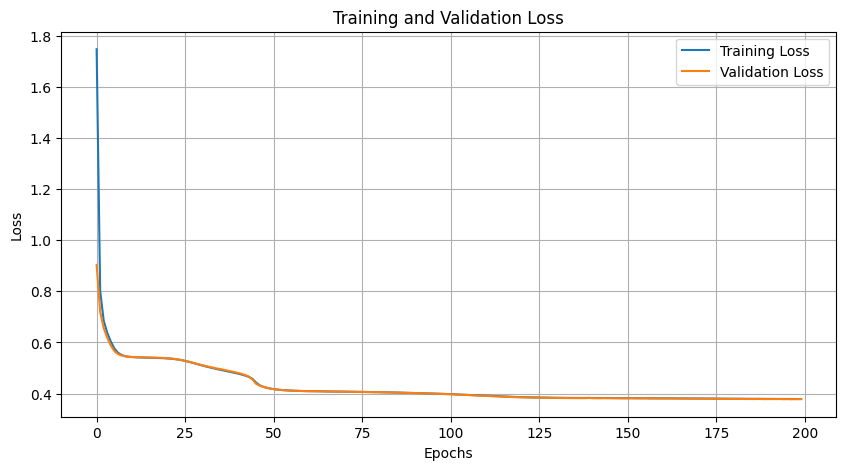

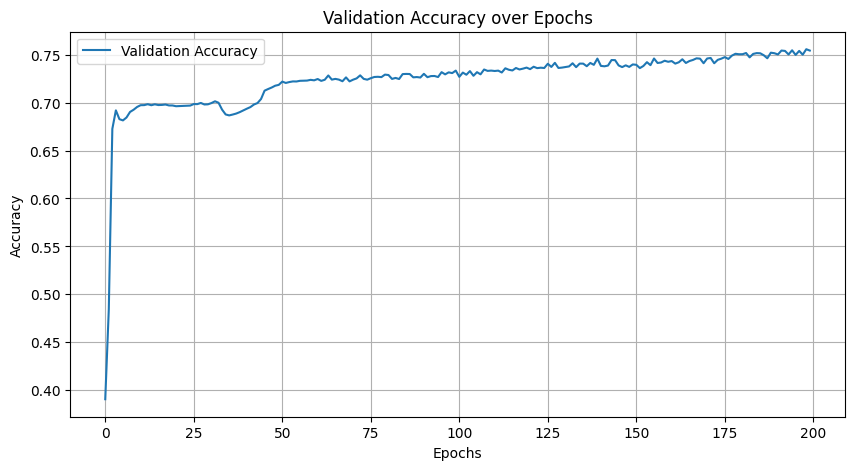

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Init model with Trivial Rep
in_type = FieldType(flipRot2dOnR2(N=4), [flipRot2dOnR2(N=4).trivial_repr])
latent_type = FieldType(flipRot2dOnR2(N=4), [flipRot2dOnR2(N=4).trivial_repr])
out_type = FieldType(flipRot2dOnR2(N=4), [flipRot2dOnR2(N=4).trivial_repr]*2)

# # Initialize FieldTypes with regular representations
# g = flipRot2dOnR2(N=4)  # Group with N-fold rotational symmetry
# in_type = FieldType(g, [g.regular_repr])  # Using regular representation for input
# latent_type = FieldType(g, [g.regular_repr] * 8)  # Latent space
# out_type = FieldType(g, [g.regular_repr] * 2)  # Output

model = AutoEncoder(in_type, out_type, latent_type)


model = model.to(device)
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Optimizer

# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=50, gamma=0.2)

num_epochs = 200
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).squeeze().long()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Update learning rate
    # scheduler.step()

    # Validation phase
    val_loss = 0
    val_acc = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).squeeze().long()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

            val_acc += (F.softmax(outputs, dim=1).argmax(dim=1) == targets).sum().float()

    val_loss /= len(val_loader.dataset)
    val_acc /= (len(val_loader.dataset) * 144)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Node Type Accuracy: {val_acc:.4f}")


# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

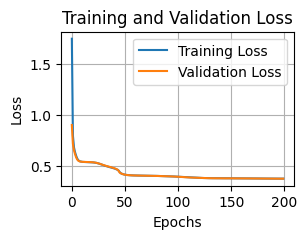

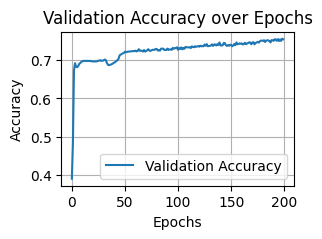

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(3,2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot the validation accuracy
plt.figure(figsize=(3,2))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# saving losses
import pickle

# Save train and validation losses
with open('/content/train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)

with open('/content/val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses, f)


In [ ]:
from google.colab import files

# Download files
files.download('/content/train_losses.pkl')
files.download('/content/val_losses.pkl')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: Cannot find file: /content/losses.csv